## GluonCV on SageMaker demo

This notebook has to be executed on a SageMaker notebook instance. It will download the pre-trained GluonCV model and deploy the endpoint.


In [ ]:
!pip install gluoncv


First we import some modules and create a SageMaker session.

In [ ]:
import sagemaker
import mxnet as mx
import matplotlib.pyplot as plt
from sagemaker.mxnet import MXNet
from gluoncv import model_zoo, data, utils
import gluoncv as gcv
import glob
import math
import numpy as np
import json
import cv2
import os
import tarfile

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
print (role)

Next we define the S3 Bucket where the pre-trained model will be stored.

### Object Detection with a pre-trained SSD model

First we get a pre-trained SSD model from the GluonCV model zoo and save it to local hard drive.

In [3]:
model = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)
utils.export_block('model/model', model, preprocess=True)
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('model', recursive=True)

Next we upload the model artefacts to the SageMaker default bucket in Amazon S3.

In [4]:
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

Now we define an MXNetModel and define the entry_point file. `pretrained_object_detection.py` defines the functions for inference.

In [5]:
from sagemaker.mxnet import MXNetModel
sagemaker_model = MXNetModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                              role = role,
                              framework_version = '1.4.1',
                              source_dir='entry_point',
                              entry_point = 'pretrained_object_detection.py',
                              py_version='py3')

Now we deploy the pretrained model so that we can invoke workloads from our local machine.

In [ ]:
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m5.large',
                                   endpoint_name='gluoncv-pretrained-object-detection-ssd'
                                  )

Now we can test the deployed endpoint by sending some images from the notebook instance.

In [88]:
im_fname = utils.download('https://images2.minutemediacdn.com/image/upload/c_crop,h_1689,w_3000,x_0,y_404/f_auto,q_auto,w_1100/v1563809078/shape/mentalfloss/28865-gettyimages-500694766.jpg', path='street_small.jpg')
img = cv2.resize(img, dsize=(512, 512))

Perform the test and plot predictions.

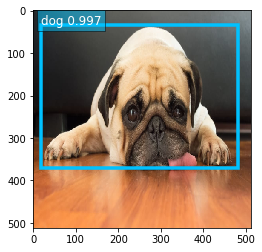

In [89]:
output = predictor.predict(img)
[class_IDs, scores, bounding_boxes] = output
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)
bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
ax = utils.viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

### Transfer learning: detect AWS logos with pre-trained SSD model

We will use SageMaker Groundtruth to train GluonCV's SSD model to detect AWS logos. 


Bounding boxes

In [32]:
!aws s3 cp s3://gluoncv-on-sagemaker/aws-logo-detection/manifests/output/output.manifest .

download: s3://gluoncv-on-sagemaker/aws-logo-detection/manifests/output/output.manifest to ./output.manifest


On each image, there is one or more logos. We can read this information from the `output.manifest` file.

In [26]:
image_info = []
with open('output.manifest') as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))

In [28]:
info = image_info[10]
info

{'source-ref': 's3://object-detection-aws-logos/19.jpg',
 'aws-logo-detection': {'annotations': [{'class_id': 0,
    'width': 378,
    'top': 120,
    'height': 372,
    'left': 58}],
  'image_size': [{'width': 512, 'depth': 3, 'height': 512}]},
 'aws-logo-detection-metadata': {'job-name': 'labeling-job/aws-logo-detection',
  'class-map': {'0': 'AWS'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.09}],
  'creation-date': '2019-11-18T23:49:33.692059',
  'type': 'groundtruth/object-detection'}}

Let's plot some of the labels:

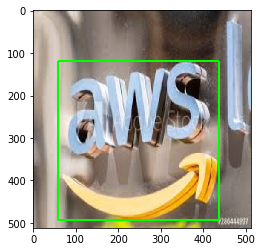

In [29]:
task = "aws-logo-detection"
class_map = info[task+'-metadata']['class-map']
image = plt.imread(os.path.join("aws_logos",info['source-ref'].split('/')[-1]))
boxes = info[task]['annotations']
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

### Transfer learning: detect AWS logos with pre-trained SSD model

We will use SageMaker Groundtruth to train GluonCV's SSD model to detect AWS logos. 

In [54]:
mxnet_estimator = MXNet(entry_point='train_aws_logo_detection_ssd.py',
                        source_dir='entry_point',
                        role=role,
                        train_instance_type='ml.p2.xlarge',
                        train_instance_count=1,
                        framework_version='1.4.0', py_version='py3')

In [55]:
s3_train_data = 's3://gluoncv-demo-sagemaker/aws-logos'
s3_label_data = 's3://aws-logos-groundtruth/aws-logo-detection/manifests/output/'

In [ ]:
mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data})

In [ ]:
predictor = mxnet_estimator.deploy(
            instance_type='ml.m5.xlarge', 
            initial_instance_count=1,
            endpoint_name="gluoncv-aws-logo-detection"
)

### Optimize the model for inference with SageMaker Neo

In [73]:
output_path="s3://neo-compiled-models"

Create compilation job: We optimize the model for a c5 instance. 

In [74]:
compiled_model = mxnet_estimator.compile_model(target_instance_family='ml_c5', 
                                               input_shape={'data':[1,3,512,512]},
                                               role=role,
                                               output_path=output_path)

?.......!

In [77]:
predictor_optimized = compiled_model.deploy(initial_instance_count = 1, 
                                            instance_type = 'ml.c5.4xlarge',
                                            endpoint_name="gluoncv-aws-logo-detection-neo")

--------------------------------------------------------------------------------------!